## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.1
GPU Available: []


## 2. Data Acquisition

We'll use the CIFAR-10 dataset which contains 60,000 32x32 color images in 10 classes:
- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

In [2]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Image dimensions: {X_train.shape[1:]}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 567s 3us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 567s 3us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Number of classes: 10
Image dimensions: (32, 32, 3)
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Number of classes: 10
Image dimensions: (32, 32, 3)


## 3. Exploratory Data Analysis and Visualizations

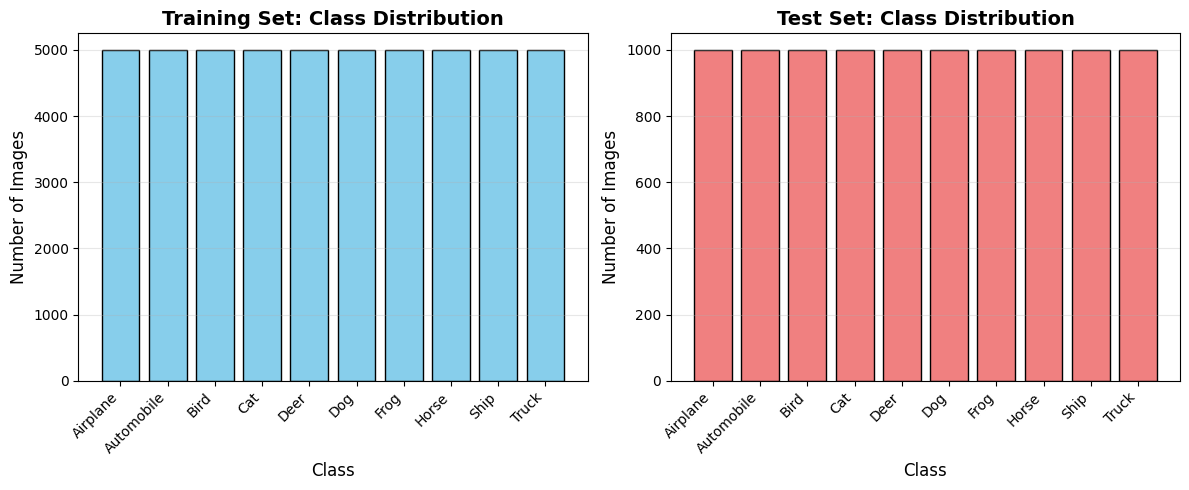


📊 Interpretation 1: Class Distribution
The dataset is perfectly balanced with 5,000 training images
and 1,000 test images per class. This balanced distribution
ensures the model won't be biased towards any particular class.


In [3]:
# Visualization 1: Class Distribution in Training Set
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar([class_names[i] for i in unique], counts, color='skyblue', edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Training Set: Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
unique_test, counts_test = np.unique(y_test, return_counts=True)
plt.bar([class_names[i] for i in unique_test], counts_test, color='lightcoral', edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Test Set: Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../static/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Interpretation 1: Class Distribution")
print("="*60)
print("The dataset is perfectly balanced with 5,000 training images")
print("and 1,000 test images per class. This balanced distribution")
print("ensures the model won't be biased towards any particular class.")

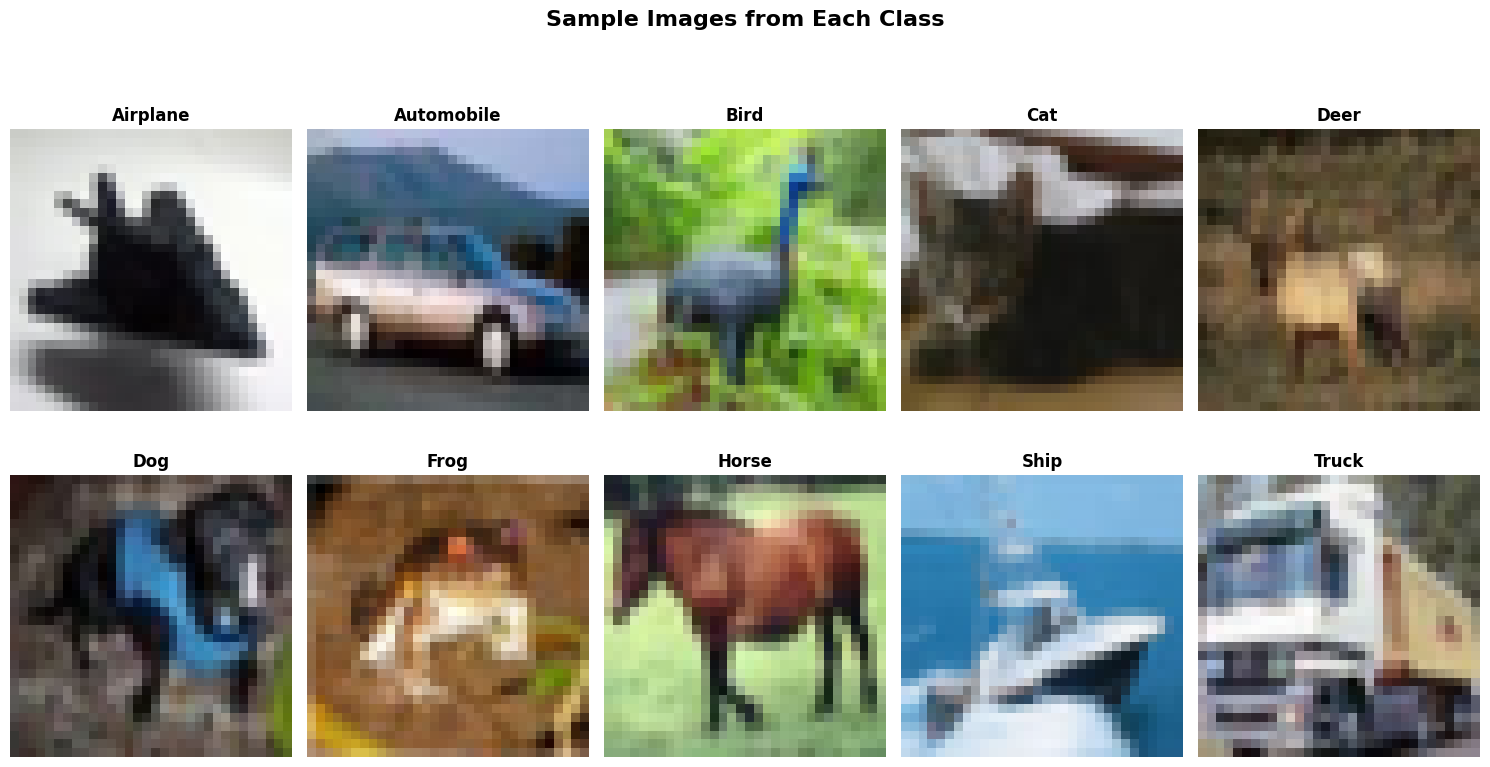


📊 Interpretation 2: Visual Inspection of Classes
The images are 32x32 pixels with RGB colors. Despite the low
resolution, human-identifiable features are visible. This suggests
that a CNN should be able to extract meaningful patterns for
classification.


In [4]:
# Visualization 2: Sample Images from Each Class
plt.figure(figsize=(15, 8))
for i in range(10):
    # Get first image of each class
    idx = np.where(y_train == i)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f'{class_names[i]}', fontsize=12, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../static/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Interpretation 2: Visual Inspection of Classes")
print("="*60)
print("The images are 32x32 pixels with RGB colors. Despite the low")
print("resolution, human-identifiable features are visible. This suggests")
print("that a CNN should be able to extract meaningful patterns for")
print("classification.")

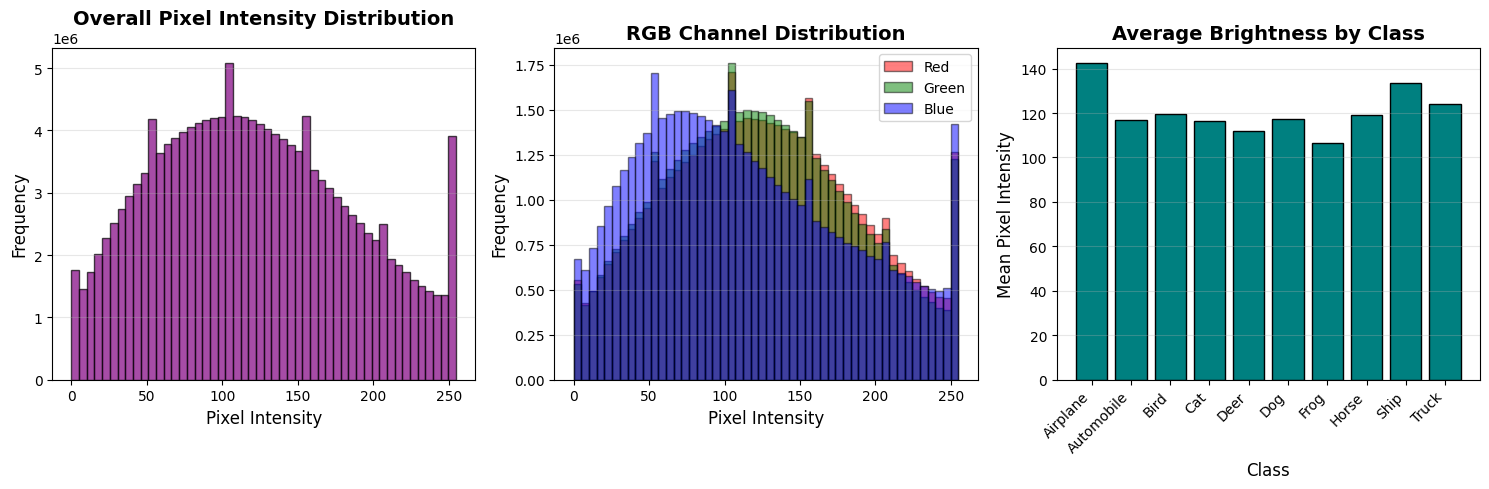


📊 Interpretation 3: Pixel Intensity Analysis
The pixel intensity distribution shows a fairly uniform spread
across all values (0-255), indicating diverse image content.
RGB channels show similar distributions, suggesting no severe
color bias. Different classes have varying average brightness,
which can be a useful feature for classification.


In [5]:
# Visualization 3: Pixel Intensity Distribution
plt.figure(figsize=(15, 5))

# Overall pixel distribution
plt.subplot(1, 3, 1)
plt.hist(X_train.flatten(), bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Pixel Intensity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Overall Pixel Intensity Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# RGB Channel distributions
plt.subplot(1, 3, 2)
colors = ['red', 'green', 'blue']
channel_names = ['Red', 'Green', 'Blue']
for i, (color, name) in enumerate(zip(colors, channel_names)):
    plt.hist(X_train[:, :, :, i].flatten(), bins=50, alpha=0.5, 
             label=name, color=color, edgecolor='black')
plt.xlabel('Pixel Intensity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('RGB Channel Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Mean pixel values per class
plt.subplot(1, 3, 3)
mean_values = [X_train[y_train.flatten() == i].mean() for i in range(10)]
plt.bar(class_names, mean_values, color='teal', edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Mean Pixel Intensity', fontsize=12)
plt.title('Average Brightness by Class', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../static/pixel_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Interpretation 3: Pixel Intensity Analysis")
print("="*60)
print("The pixel intensity distribution shows a fairly uniform spread")
print("across all values (0-255), indicating diverse image content.")
print("RGB channels show similar distributions, suggesting no severe")
print("color bias. Different classes have varying average brightness,")
print("which can be a useful feature for classification.")

## 4. Data Preprocessing

In [6]:
# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

print(f"Normalized training data shape: {X_train_normalized.shape}")
print(f"Normalized test data shape: {X_test_normalized.shape}")
print(f"Categorical training labels shape: {y_train_categorical.shape}")
print(f"Categorical test labels shape: {y_test_categorical.shape}")
print(f"\nSample pixel values before normalization: {X_train[0, 0, 0, :]}")
print(f"Sample pixel values after normalization: {X_train_normalized[0, 0, 0, :]}")

Normalized training data shape: (50000, 32, 32, 3)
Normalized test data shape: (10000, 32, 32, 3)
Categorical training labels shape: (50000, 10)
Categorical test labels shape: (10000, 10)

Sample pixel values before normalization: [59 62 63]
Sample pixel values after normalization: [0.23137255 0.24313726 0.24705882]


## 5. Model Creation

We'll create a Convolutional Neural Network (CNN) architecture optimized for CIFAR-10 classification.

In [7]:
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Create a CNN model for image classification.
    
    Architecture:
    - 3 Convolutional blocks with increasing filters
    - Batch Normalization for stable training
    - MaxPooling for dimensionality reduction
    - Dropout for regularization
    - Dense layers for classification
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
model = create_cnn_model()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 849,066 (3.24 MB)

 Trainable params: 847,402 (3.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Calculate total parameters
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\nTotal trainable parameters: {trainable_params:,}")

## 6. Model Training

In [9]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("Starting model training...\n")
history = model.fit(
    X_train_normalized, y_train_categorical,
    batch_size=64,
    epochs=6,
    validation_data=(X_test_normalized, y_test_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")

Starting model training...

Epoch 1/6
Epoch 1/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 452s 577ms/step - accuracy: 0.3191 - loss: 2.1049 - val_accuracy: 0.5224 - val_loss: 1.3155 - learning_rate: 0.0010
Epoch 2/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 452s 577ms/step - accuracy: 0.3191 - loss: 2.1049 - val_accuracy: 0.5224 - val_loss: 1.3155 - learning_rate: 0.0010
Epoch 2/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 462s 590ms/step - accuracy: 0.5616 - loss: 1.2215 - val_accuracy: 0.6534 - val_loss: 0.9975 - learning_rate: 0.0010
Epoch 3/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 462s 590ms/step - accuracy: 0.5616 - loss: 1.2215 - val_accuracy: 0.6534 - val_loss: 0.9975 - learning_rate: 0.0010
Epoch 3/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 392s 449ms/step - accuracy: 0.6570 - loss: 0.9829 - val_accuracy: 0.7184 - val_loss: 0.8026 - learning_rate: 0.0010
Epoch 4/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 392s 449ms/step - accuracy: 0.6570 - loss: 0.9829 - val_accuracy: 0.7184 - val_loss: 0.8026 - learning_rate: 0.0010
Epoch 4/6
782/782 ━━━━━━━━━━━━━━

## 7. Training History Visualization

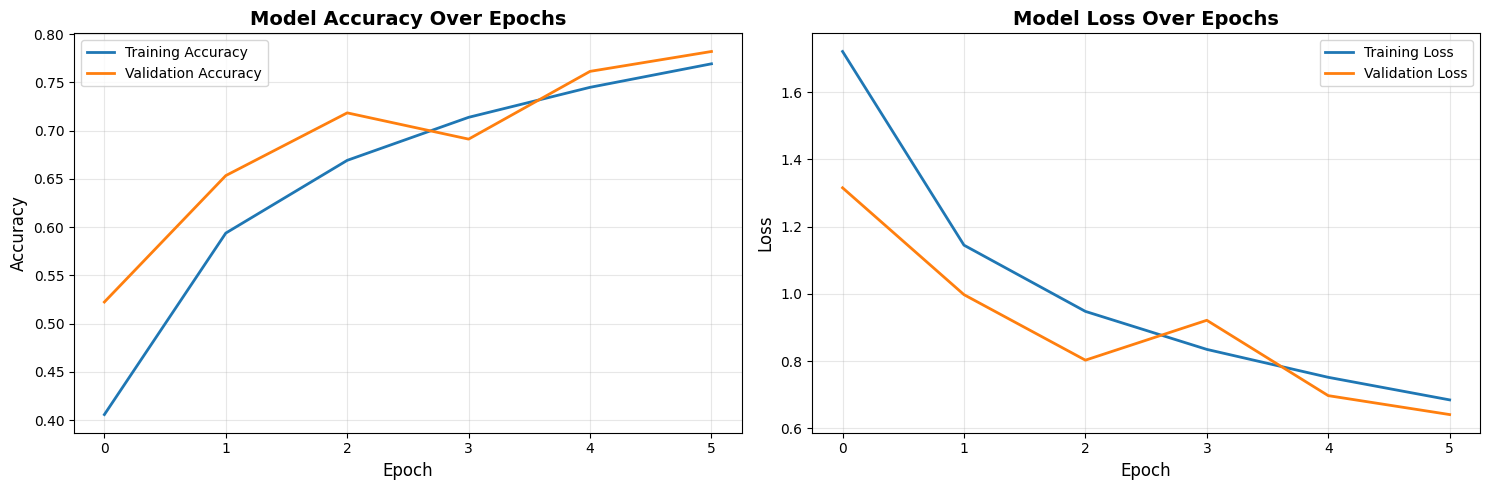

In [10]:
# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../static/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Model Evaluation - Comprehensive Metrics

In [11]:
# Make predictions on test set
y_pred_proba = model.predict(X_test_normalized)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test.flatten()

print("Predictions completed!")
print(f"Prediction shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step
Predictions completed!
Prediction shape: (10000,)
True labels shape: (10000,)
Predictions completed!
Prediction shape: (10000,)
True labels shape: (10000,)


### 8.1 Overall Metrics

In [12]:
# Calculate overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Display overall metrics
print("="*70)
print("MODEL EVALUATION METRICS")
print("="*70)
print(f"\n{'Metric':<30} {'Score':<20}")
print("-"*70)
print(f"{'Accuracy':<30} {accuracy:<20.4f}")
print(f"{'Precision (Macro)':<30} {precision_macro:<20.4f}")
print(f"{'Precision (Weighted)':<30} {precision_weighted:<20.4f}")
print(f"{'Recall (Macro)':<30} {recall_macro:<20.4f}")
print(f"{'Recall (Weighted)':<30} {recall_weighted:<20.4f}")
print(f"{'F1-Score (Macro)':<30} {f1_macro:<20.4f}")
print(f"{'F1-Score (Weighted)':<30} {f1_weighted:<20.4f}")
print("="*70)

# Store metrics in a dictionary
metrics_dict = {
    'accuracy': accuracy,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted
}

MODEL EVALUATION METRICS

Metric                         Score               
----------------------------------------------------------------------
Accuracy                       0.7820              
Precision (Macro)              0.7814              
Precision (Weighted)           0.7814              
Recall (Macro)                 0.7820              
Recall (Weighted)              0.7820              
F1-Score (Macro)               0.7772              
F1-Score (Weighted)            0.7772              


### 8.2 Per-Class Metrics


CLASSIFICATION REPORT (Per-Class Metrics)
              precision    recall  f1-score   support

    Airplane     0.8207    0.7600    0.7892      1000
  Automobile     0.8957    0.8930    0.8943      1000
        Bird     0.7447    0.6270    0.6808      1000
         Cat     0.7350    0.4910    0.5887      1000
        Deer     0.6862    0.8330    0.7525      1000
         Dog     0.6999    0.6950    0.6974      1000
        Frog     0.8163    0.8530    0.8342      1000
       Horse     0.7674    0.8580    0.8102      1000
        Ship     0.8237    0.9020    0.8611      1000
       Truck     0.8240    0.9080    0.8639      1000

    accuracy                         0.7820     10000
   macro avg     0.7814    0.7820    0.7772     10000
weighted avg     0.7814    0.7820    0.7772     10000



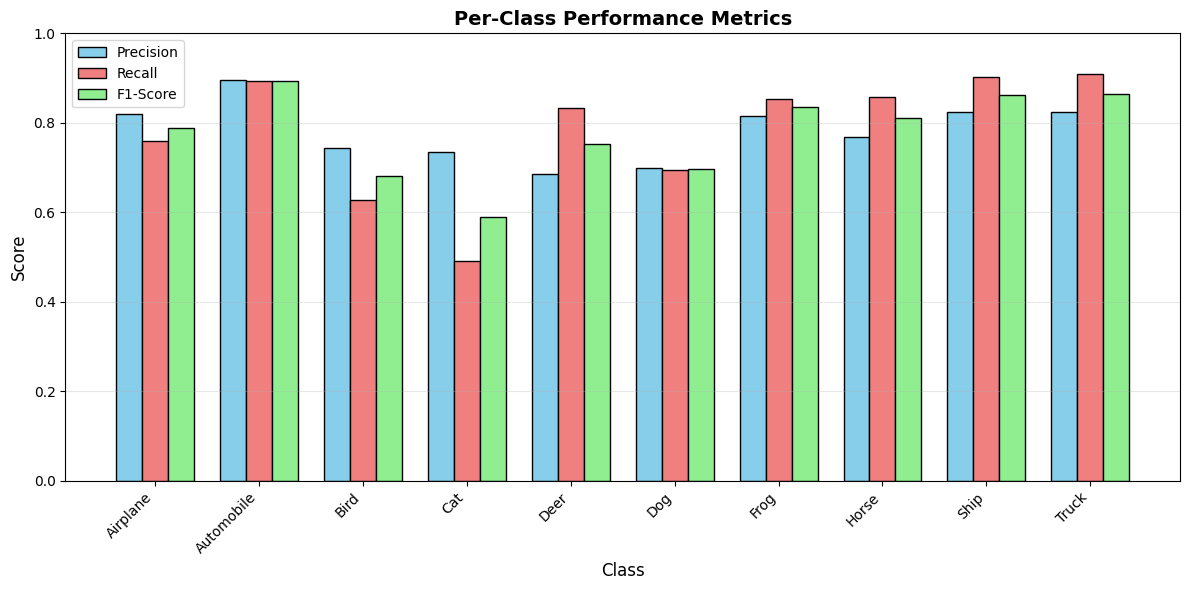

In [13]:
# Classification report
print("\nCLASSIFICATION REPORT (Per-Class Metrics)")
print("="*70)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Create DataFrame for visualization
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.iloc[:-3, :]  # Remove macro, weighted, accuracy rows

# Visualize per-class metrics
plt.figure(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, report_df['precision'], width, label='Precision', color='skyblue', edgecolor='black')
plt.bar(x, report_df['recall'], width, label='Recall', color='lightcoral', edgecolor='black')
plt.bar(x + width, report_df['f1-score'], width, label='F1-Score', color='lightgreen', edgecolor='black')

plt.xlabel('Class', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.legend(fontsize=10)
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../static/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.3 Confusion Matrix

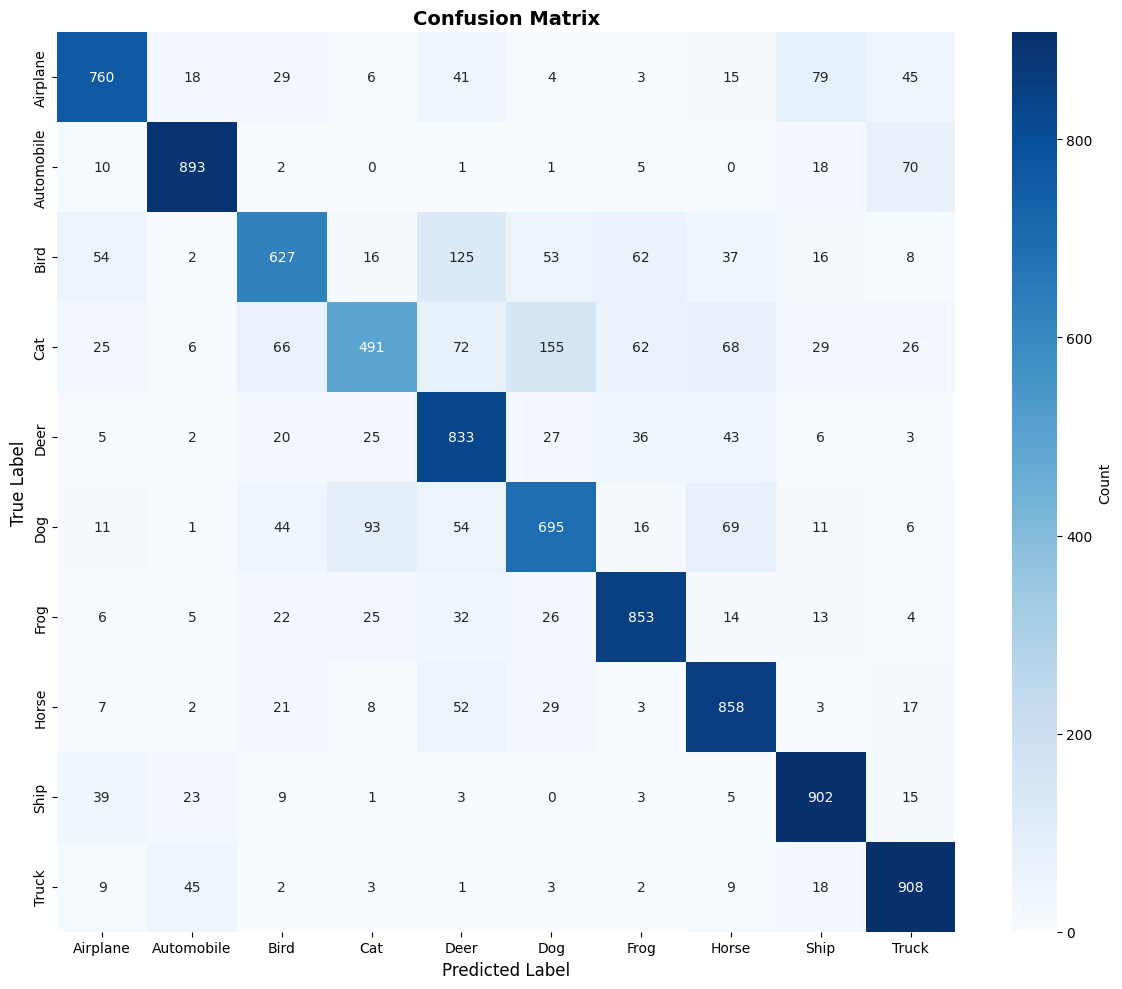

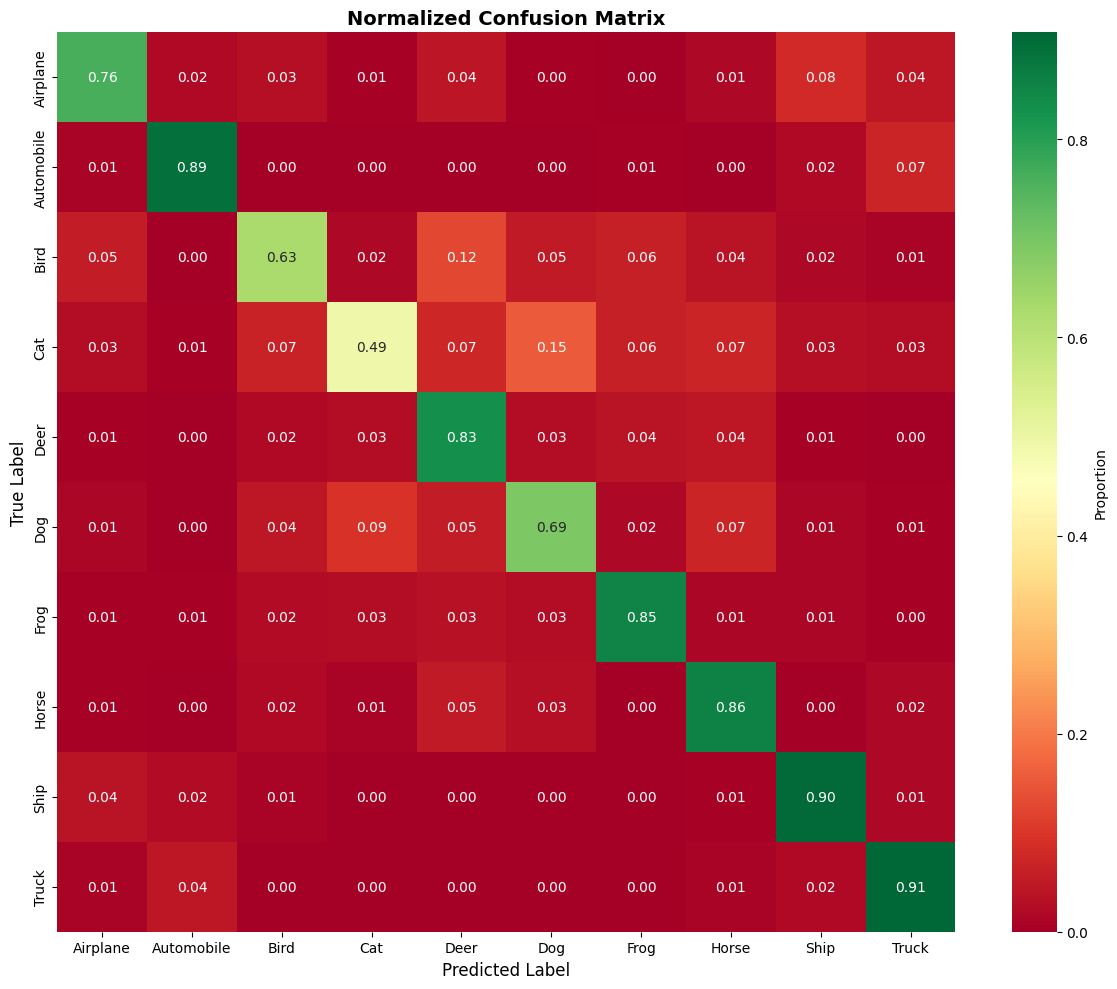

In [14]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../static/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../static/confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.4 ROC Curves and AUC Scores

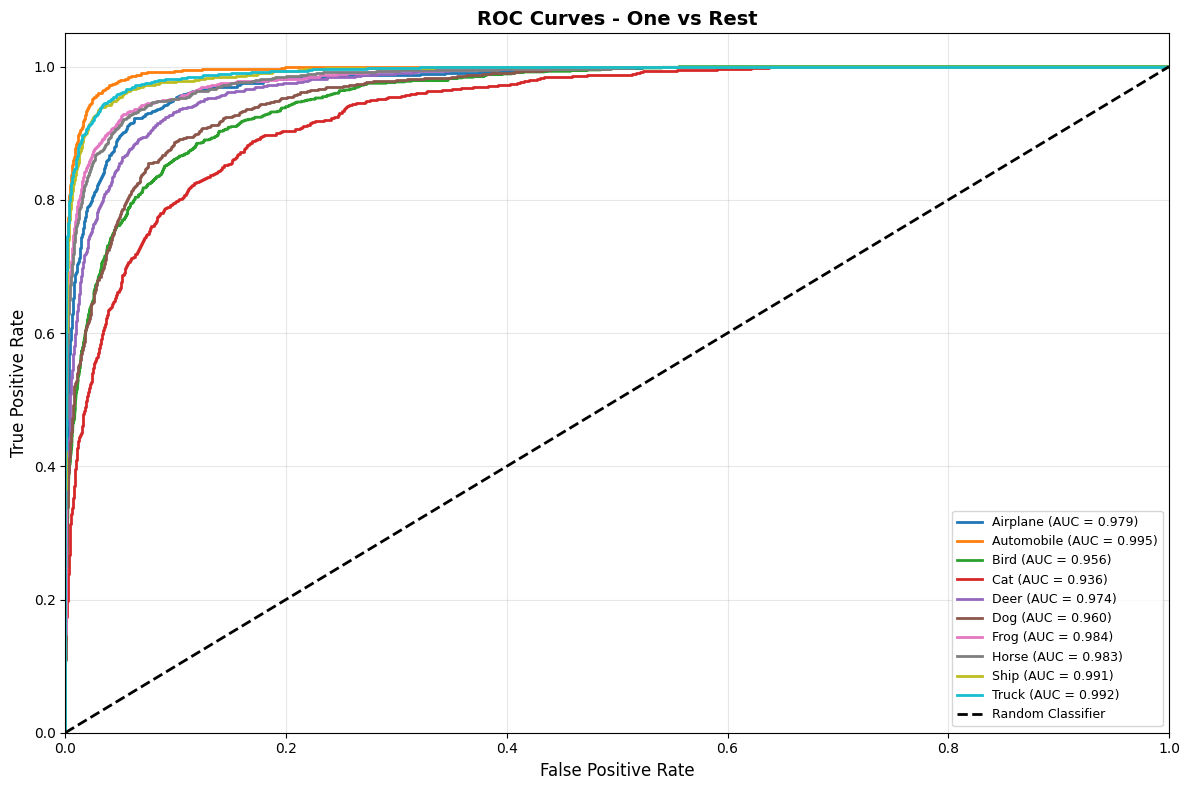


AUC Scores per Class:
Airplane        : 0.9788
Automobile      : 0.9949
Bird            : 0.9558
Cat             : 0.9357
Deer            : 0.9738
Dog             : 0.9604
Frog            : 0.9840
Horse           : 0.9831
Ship            : 0.9911
Truck           : 0.9917
Mean AUC        : 0.9749


In [15]:
# Binarize labels for ROC curve (one-vs-rest)
y_true_binarized = label_binarize(y_true, classes=range(10))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_pred_proba[:, i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - One vs Rest', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../static/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print AUC scores
print("\nAUC Scores per Class:")
print("="*40)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} : {roc_auc[i]:.4f}")
print("="*40)
print(f"{'Mean AUC':<15} : {np.mean(list(roc_auc.values())):.4f}")

## 9. Model Testing - Prediction Examples

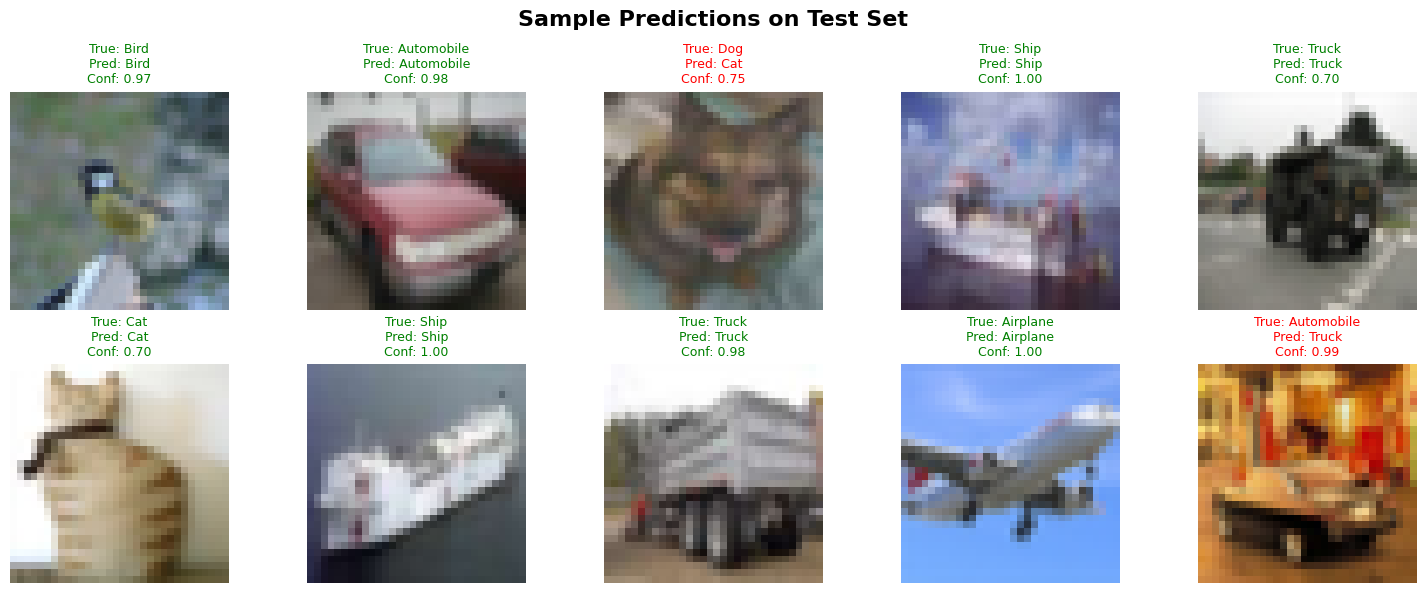

In [16]:
# Select random test samples
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    
    # Make prediction
    img = X_test_normalized[idx:idx+1]
    pred_proba = model.predict(img, verbose=0)
    pred_class = np.argmax(pred_proba)
    confidence = pred_proba[0][pred_class]
    true_class = y_test[idx][0]
    
    # Color code: green if correct, red if incorrect
    color = 'green' if pred_class == true_class else 'red'
    
    plt.title(f'True: {class_names[true_class]}\nPred: {class_names[pred_class]}\nConf: {confidence:.2f}',
              fontsize=9, color=color)
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../static/sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Prediction Function for Single Image

In [17]:
def predict_single_image(image, model, class_names):
    """
    Predict class for a single image.
    
    Args:
        image: Input image (32x32x3)
        model: Trained model
        class_names: List of class names
    
    Returns:
        predicted_class: Predicted class name
        confidence: Prediction confidence
        probabilities: All class probabilities
    """
    # Normalize image
    img_normalized = image.astype('float32') / 255.0
    img_normalized = np.expand_dims(img_normalized, axis=0)
    
    # Make prediction
    predictions = model.predict(img_normalized, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    return predicted_class, confidence, predictions[0]

# Test the function
test_idx = 42
test_image = X_test[test_idx]
pred_class, conf, probs = predict_single_image(test_image, model, class_names)

print(f"Predicted Class: {pred_class}")
print(f"Confidence: {conf:.4f}")
print(f"\nAll class probabilities:")
for i, (name, prob) in enumerate(zip(class_names, probs)):
    print(f"{name:<15} : {prob:.4f}")

Predicted Class: Horse
Confidence: 0.4973

All class probabilities:
Airplane        : 0.0058
Automobile      : 0.0007
Bird            : 0.0572
Cat             : 0.1977
Deer            : 0.0108
Dog             : 0.2149
Frog            : 0.0014
Horse           : 0.4973
Ship            : 0.0017
Truck           : 0.0126


## 11. Save the Model and Metadata

In [ ]:
# Save model in multiple formats
model_path_keras = '../models/cifar10_cnn_model.keras'
model_path_tf = '../models/cifar10_cnn_model'

# Save as native Keras format (recommended)
model.save(model_path_keras)
print(f"Model saved as Keras format: {model_path_keras}")

# Export as TensorFlow SavedModel format
model.export(model_path_tf)
print(f"Model exported as TensorFlow SavedModel: {model_path_tf}")

# Save model metadata
metadata = {
    'class_names': class_names,
    'input_shape': (32, 32, 3),
    'num_classes': 10,
    'metrics': metrics_dict,
    'training_history': {
        'epochs': len(history.history['loss']),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1])
    }
}

with open('../models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("Model metadata saved: ../models/model_metadata.pkl")

# Save training history
with open('../models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Training history saved: ../models/training_history.pkl")

print("\n✅ All models and metadata saved successfully!")

Model saved as Keras format: ../models/cifar10_cnn_model.keras
INFO:tensorflow:Assets written to: ../models/cifar10_cnn_model\assets
INFO:tensorflow:Assets written to: ../models/cifar10_cnn_model\assets


INFO:tensorflow:Assets written to: ../models/cifar10_cnn_model\assets


Saved artifact at '../models/cifar10_cnn_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1995638092048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638091280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638089936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638091088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638093392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638090128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638085520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638085712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638083792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638085904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1995638089744: TensorSpe

## 12. Model Quality Assessment

### Summary of Model Performance

In [20]:
print("="*80)
print("COMPREHENSIVE MODEL QUALITY ASSESSMENT")
print("="*80)

print("\n📊 OVERALL PERFORMANCE:")
print("-" * 80)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Macro F1-Score: {f1_macro:.4f}")
print(f"Mean AUC: {np.mean(list(roc_auc.values())):.4f}")

print("\n🎯 MODEL STRENGTHS:")
print("-" * 80)
# Find best performing classes
best_f1_classes = report_df['f1-score'].nlargest(3)
for class_name, f1 in best_f1_classes.items():
    print(f"  • {class_name}: F1-Score = {f1:.4f}")

print("\n⚠️  MODEL WEAKNESSES:")
print("-" * 80)
# Find worst performing classes
worst_f1_classes = report_df['f1-score'].nsmallest(3)
for class_name, f1 in worst_f1_classes.items():
    print(f"  • {class_name}: F1-Score = {f1:.4f}")

print("\n📈 TRAINING CHARACTERISTICS:")
print("-" * 80)
print(f"Total Epochs Trained: {len(history.history['loss'])}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
overfitting_gap = abs(history.history['accuracy'][-1] - history.history['val_accuracy'][-1])
print(f"Overfitting Gap: {overfitting_gap*100:.2f}%")

if overfitting_gap < 0.05:
    print("  ✅ Model shows good generalization (low overfitting)")
elif overfitting_gap < 0.10:
    print("  ⚠️  Model shows moderate overfitting")
else:
    print("  ❌ Model shows significant overfitting")

print("\n🔍 CONCLUSION:")
print("-" * 80)
if accuracy > 0.85:
    print("  ✅ EXCELLENT: Model demonstrates strong performance across all metrics.")
elif accuracy > 0.75:
    print("  ✅ GOOD: Model shows good performance with room for improvement.")
elif accuracy > 0.65:
    print("  ⚠️  ACCEPTABLE: Model performance is acceptable but needs optimization.")
else:
    print("  ❌ POOR: Model requires significant improvement.")

print("\n💡 RECOMMENDATIONS:")
print("-" * 80)
print("  • Monitor model performance on new data regularly")
print("  • Retrain model when accuracy drops below 75%")
print("  • Consider data augmentation for weak-performing classes")
print("  • Implement A/B testing when deploying model updates")
print("="*80)

COMPREHENSIVE MODEL QUALITY ASSESSMENT

📊 OVERALL PERFORMANCE:
--------------------------------------------------------------------------------
Test Accuracy: 78.20%
Macro F1-Score: 0.7772
Mean AUC: 0.9749

🎯 MODEL STRENGTHS:
--------------------------------------------------------------------------------
  • Automobile: F1-Score = 0.8943
  • Truck: F1-Score = 0.8639
  • Ship: F1-Score = 0.8611

⚠️  MODEL WEAKNESSES:
--------------------------------------------------------------------------------
  • Cat: F1-Score = 0.5887
  • Bird: F1-Score = 0.6808
  • Dog: F1-Score = 0.6974

📈 TRAINING CHARACTERISTICS:
--------------------------------------------------------------------------------
Total Epochs Trained: 6
Final Training Accuracy: 76.92%
Final Validation Accuracy: 78.20%
Overfitting Gap: 1.28%
  ✅ Model shows good generalization (low overfitting)

🔍 CONCLUSION:
--------------------------------------------------------------------------------
  ✅ GOOD: Model shows good performance with

## 13. Export Test Data Samples

Save some test samples for use in the web application

In [21]:
# Save some test samples for the web application
sample_data = {
    'images': X_test[:100],
    'labels': y_test[:100],
    'class_names': class_names
}

with open('../data/test_samples.pkl', 'wb') as f:
    pickle.dump(sample_data, f)

print("Test samples saved for web application: ../data/test_samples.pkl")
print(f"Saved {len(sample_data['images'])} test images")

Test samples saved for web application: ../data/test_samples.pkl
Saved 100 test images
